# Token Lifecycles: First-Time-Last-Time Phase Transitions

**Question:** When do tokens *definitively* transition between phases?

Instead of counting every boundary crossing as a transition, we compute:
- **Last Hypernova:** final step where |ΔW′|₂ > 1000
- **Last Superluminal:** final step where |ΔW′|₂ > √D
- **Last Spherical:** final step where L1 > 1
- **Last Stumbling:** final step where L1 > 0 (final motion before freeze)

Each token's life is a sequence of phases with definitive transition points. We visualize all 3,699 tokens as 1-pixel-high horizontal lines colored by phase.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from safetensors.torch import load_file
from pathlib import Path

# Device detection
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent
CRUCIBLE_1_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-1' / 'crucible_1_trajectory.safetensors'

# Style
plt.rcParams['figure.dpi'] = 200

# Phase thresholds
D = 64
SQRT_D = np.sqrt(D)  # ~8.0
THRESH_SUPERLUMINAL = 1000.0

# Random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [2]:
# Load Crucible 1 trajectory data (5000 steps)
tensors = load_file(CRUCIBLE_1_PATH)

delta_W_prime = tensors['delta_W_prime']  # [5000, 3699, 64]

n_steps, n_tokens, n_dims = delta_W_prime.shape
print(f"Loaded: {n_steps} steps, {n_tokens} tokens, {n_dims} dims")

Loaded: 5000 steps, 3699 tokens, 64 dims


In [3]:
# Compute displacement norms
disp_l2 = torch.norm(delta_W_prime, dim=2)  # [5000, 3699]
disp_l1 = torch.abs(delta_W_prime).sum(dim=2)  # [5000, 3699]

# Handle any infinities
disp_l2 = torch.where(torch.isfinite(disp_l2), disp_l2, torch.zeros_like(disp_l2))
disp_l1 = torch.where(torch.isfinite(disp_l1), disp_l1, torch.zeros_like(disp_l1))

print(f"L2 range: [{disp_l2.min():.2f}, {disp_l2.max():.2f}]")
print(f"L1 range: [{disp_l1.min():.2f}, {disp_l1.max():.2f}]")

L2 range: [0.00, 9174821.00]
L1 range: [0.00, 11132284464698670435569384129847885824.00]


In [4]:
# For each token, find the LAST step in each phase
# (i.e., the definitive exit from that phase)

# Boolean masks for each phase criterion
is_hypernova = disp_l2 > THRESH_SUPERLUMINAL  # [5000, 3699]
is_superluminal_or_hotter = disp_l2 > SQRT_D
is_spherical_or_hotter = disp_l1 > 1.0
is_moving = disp_l1 > 0  # any motion at all

# Find last True for each token (along step axis)
def last_true_step(mask):
    """For each token, find the last step where mask is True. Returns -1 if never True."""
    # Flip and find first True, then convert back
    flipped = torch.flip(mask, dims=[0])
    first_in_flipped = flipped.int().argmax(dim=0)  # [n_tokens]
    # argmax returns 0 if all False, so we need to check
    any_true = mask.any(dim=0)  # [n_tokens]
    last_step = (n_steps - 1) - first_in_flipped
    last_step[~any_true] = -1
    return last_step

last_hypernova = last_true_step(is_hypernova)
last_superluminal = last_true_step(is_superluminal_or_hotter)
last_spherical = last_true_step(is_spherical_or_hotter)
last_motion = last_true_step(is_moving)

print(f"Last Hypernova: min={last_hypernova.min().item()}, max={last_hypernova.max().item()}")
print(f"Last Superluminal: min={last_superluminal.min().item()}, max={last_superluminal.max().item()}")
print(f"Last Spherical: min={last_spherical.min().item()}, max={last_spherical.max().item()}")
print(f"Last Motion: min={last_motion.min().item()}, max={last_motion.max().item()}")

Last Hypernova: min=11, max=551
Last Superluminal: min=83, max=583
Last Spherical: min=356, max=1619
Last Motion: min=559, max=2508


In [5]:
# Build a lifecycle image: [n_tokens, n_steps] with phase codes
# Phase codes: 0=Fimbulwinter, 1=Stumbling, 2=Spherical, 3=Superluminal, 4=Hypernova
#
# For each token, the lifecycle is:
#   steps 0 to last_hypernova: Hypernova (4)
#   steps last_hypernova+1 to last_superluminal: Superluminal (3)
#   steps last_superluminal+1 to last_spherical: Spherical (2)
#   steps last_spherical+1 to last_motion: Stumbling (1)
#   steps last_motion+1 to end: Fimbulwinter (0)
#
# Note: if last_X == -1, that phase never happened

lifecycle = torch.zeros((n_tokens, n_steps), dtype=torch.int8)

for token_idx in range(n_tokens):
    lh = last_hypernova[token_idx].item()
    ls = last_superluminal[token_idx].item()
    lsp = last_spherical[token_idx].item()
    lm = last_motion[token_idx].item()
    
    # Start with Fimbulwinter everywhere
    # Then paint backwards from hottest to coldest
    
    # Stumbling phase: from last_spherical+1 to last_motion
    if lm >= 0:
        start = max(0, lsp + 1) if lsp >= 0 else 0
        lifecycle[token_idx, start:lm+1] = 1  # Stumbling
    
    # Spherical phase: from last_superluminal+1 to last_spherical
    if lsp >= 0:
        start = max(0, ls + 1) if ls >= 0 else 0
        lifecycle[token_idx, start:lsp+1] = 2  # Spherical
    
    # Superluminal phase: from last_hypernova+1 to last_superluminal
    if ls >= 0:
        start = max(0, lh + 1) if lh >= 0 else 0
        lifecycle[token_idx, start:ls+1] = 3  # Superluminal
    
    # Hypernova phase: from 0 to last_hypernova
    if lh >= 0:
        lifecycle[token_idx, 0:lh+1] = 4  # Hypernova

print(f"Lifecycle image shape: {lifecycle.shape}")
print(f"Phase distribution:")
for i, name in enumerate(['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova']):
    count = (lifecycle == i).sum().item()
    print(f"  {name}: {count:,} ({100*count/(n_tokens*n_steps):.1f}%)")

Lifecycle image shape: torch.Size([3699, 5000])
Phase distribution:
  Fimbulwinter: 12,833,754 (69.4%)
  Stumbling: 2,893,090 (15.6%)
  Spherical: 2,211,853 (12.0%)
  Superluminal: 294,836 (1.6%)
  Hypernova: 261,467 (1.4%)


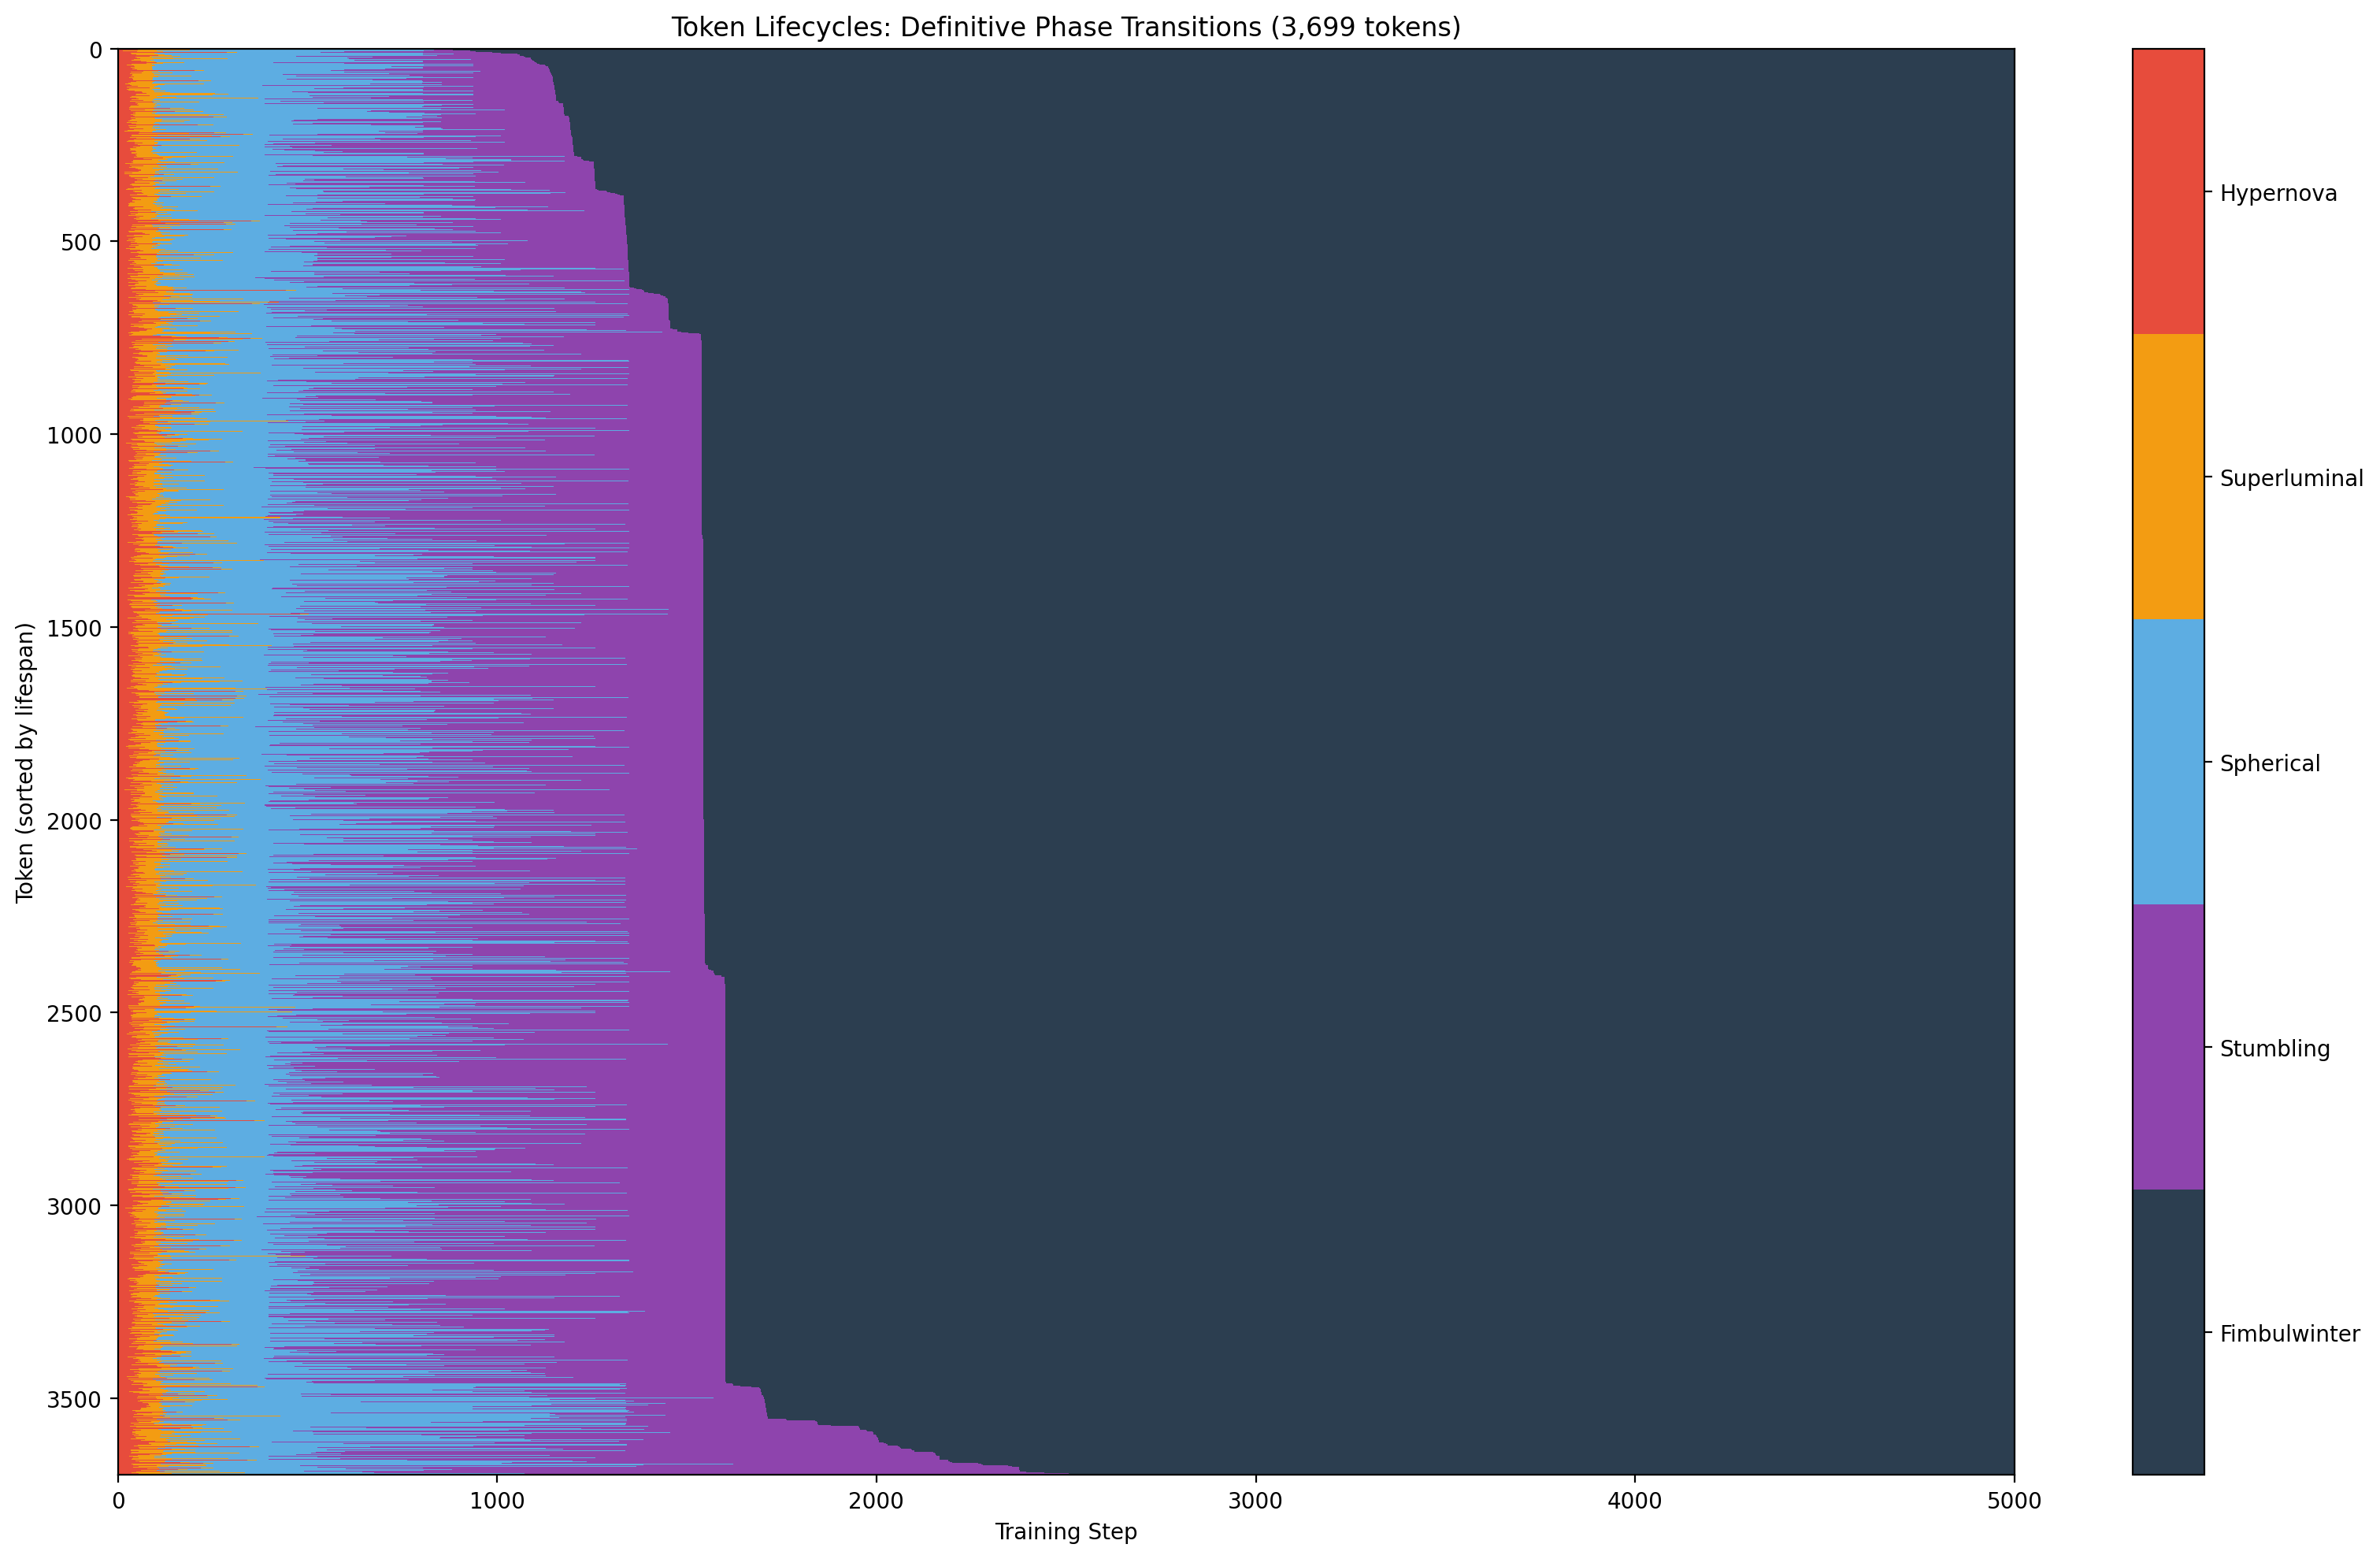

In [6]:
# Sort tokens by total lifespan (last_motion)
sort_order = torch.argsort(last_motion).numpy()
lifecycle_sorted = lifecycle[sort_order].numpy()

# Colormap: Fimbulwinter(0), Stumbling(1), Spherical(2), Superluminal(3), Hypernova(4)
cmap = ListedColormap(['#2c3e50', '#8e44ad', '#5dade2', '#f39c12', '#e74c3c'])

fig, ax = plt.subplots(figsize=(16, 10), dpi=200)

im = ax.imshow(lifecycle_sorted, aspect='auto', cmap=cmap, vmin=0, vmax=4,
               extent=[0, n_steps, n_tokens, 0], interpolation='nearest')

ax.set_xlabel('Training Step')
ax.set_ylabel('Token (sorted by lifespan)')
ax.set_title(f'Token Lifecycles: Definitive Phase Transitions ({n_tokens:,} tokens)')

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0.4, 1.2, 2.0, 2.8, 3.6])
cbar.ax.set_yticklabels(['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova'])

plt.tight_layout()
plt.show()

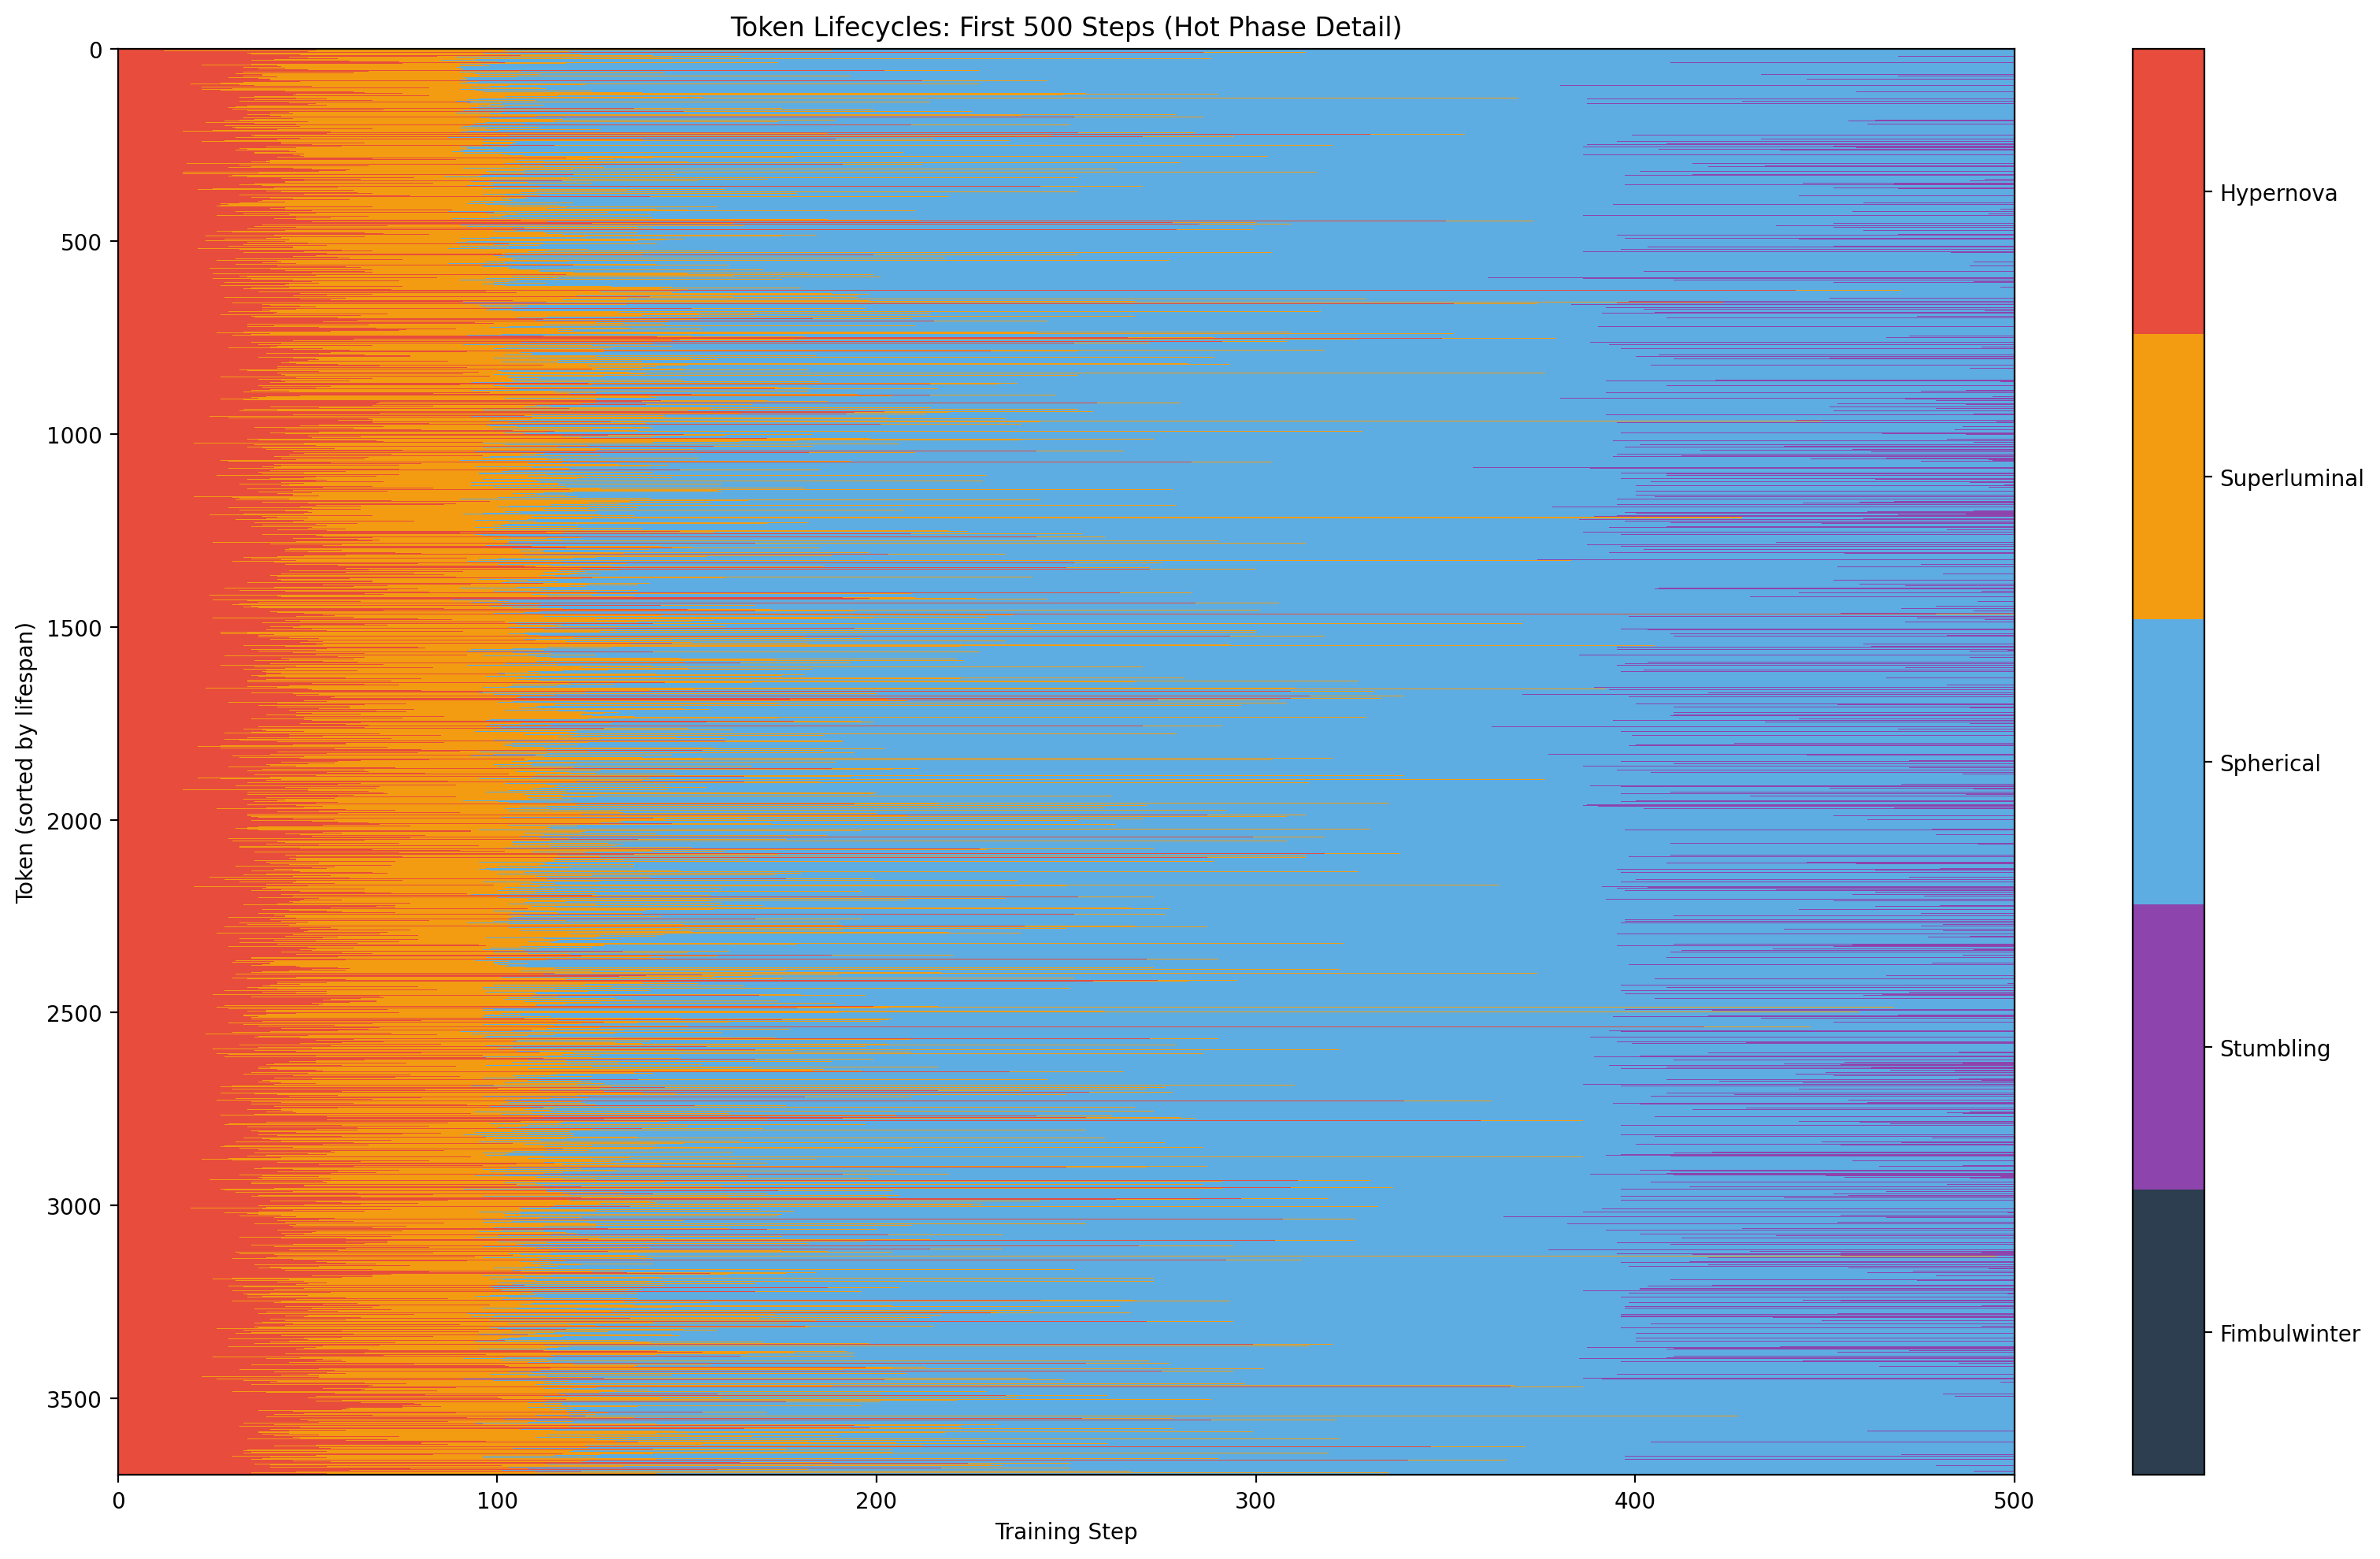

In [7]:
# Zoom to first 500 steps to see the hot phases clearly
fig, ax = plt.subplots(figsize=(16, 10), dpi=200)

im = ax.imshow(lifecycle_sorted[:, :500], aspect='auto', cmap=cmap, vmin=0, vmax=4,
               extent=[0, 500, n_tokens, 0], interpolation='nearest')

ax.set_xlabel('Training Step')
ax.set_ylabel('Token (sorted by lifespan)')
ax.set_title('Token Lifecycles: First 500 Steps (Hot Phase Detail)')

cbar = plt.colorbar(im, ax=ax, ticks=[0.4, 1.2, 2.0, 2.8, 3.6])
cbar.ax.set_yticklabels(['Fimbulwinter', 'Stumbling', 'Spherical', 'Superluminal', 'Hypernova'])

plt.tight_layout()
plt.show()

In [8]:
# Compute phase durations for each token
# Duration = time spent definitively in that phase

# Hypernova duration: 0 to last_hypernova (inclusive)
dur_hypernova = (last_hypernova + 1).clamp(min=0)

# Superluminal duration: last_hypernova+1 to last_superluminal
dur_superluminal = (last_superluminal - last_hypernova).clamp(min=0)

# Spherical duration: last_superluminal+1 to last_spherical
dur_spherical = (last_spherical - last_superluminal).clamp(min=0)

# Stumbling duration: last_spherical+1 to last_motion
dur_stumbling = (last_motion - last_spherical).clamp(min=0)

# Fimbulwinter duration: last_motion+1 to end
dur_fimbulwinter = (n_steps - 1 - last_motion).clamp(min=0)

print("Phase duration statistics (in steps):")
print(f"\nHypernova:")
print(f"  Mean: {dur_hypernova.float().mean():.1f}, Median: {dur_hypernova.float().median():.1f}")
print(f"  Min: {dur_hypernova.min().item()}, Max: {dur_hypernova.max().item()}")

print(f"\nSuperluminal:")
print(f"  Mean: {dur_superluminal.float().mean():.1f}, Median: {dur_superluminal.float().median():.1f}")
print(f"  Min: {dur_superluminal.min().item()}, Max: {dur_superluminal.max().item()}")

print(f"\nSpherical:")
print(f"  Mean: {dur_spherical.float().mean():.1f}, Median: {dur_spherical.float().median():.1f}")
print(f"  Min: {dur_spherical.min().item()}, Max: {dur_spherical.max().item()}")

print(f"\nStumbling:")
print(f"  Mean: {dur_stumbling.float().mean():.1f}, Median: {dur_stumbling.float().median():.1f}")
print(f"  Min: {dur_stumbling.min().item()}, Max: {dur_stumbling.max().item()}")

print(f"\nFimbulwinter:")
print(f"  Mean: {dur_fimbulwinter.float().mean():.1f}, Median: {dur_fimbulwinter.float().median():.1f}")
print(f"  Min: {dur_fimbulwinter.min().item()}, Max: {dur_fimbulwinter.max().item()}")

Phase duration statistics (in steps):

Hypernova:
  Mean: 70.7, Median: 52.0
  Min: 12, Max: 552

Superluminal:
  Mean: 79.7, Median: 62.0
  Min: 16, Max: 547

Spherical:
  Mean: 598.0, Median: 555.0
  Min: 92, Max: 1507

Stumbling:
  Mean: 782.1, Median: 800.0
  Min: 1, Max: 1888

Fimbulwinter:
  Mean: 3469.5, Median: 3457.0
  Min: 2491, Max: 4440


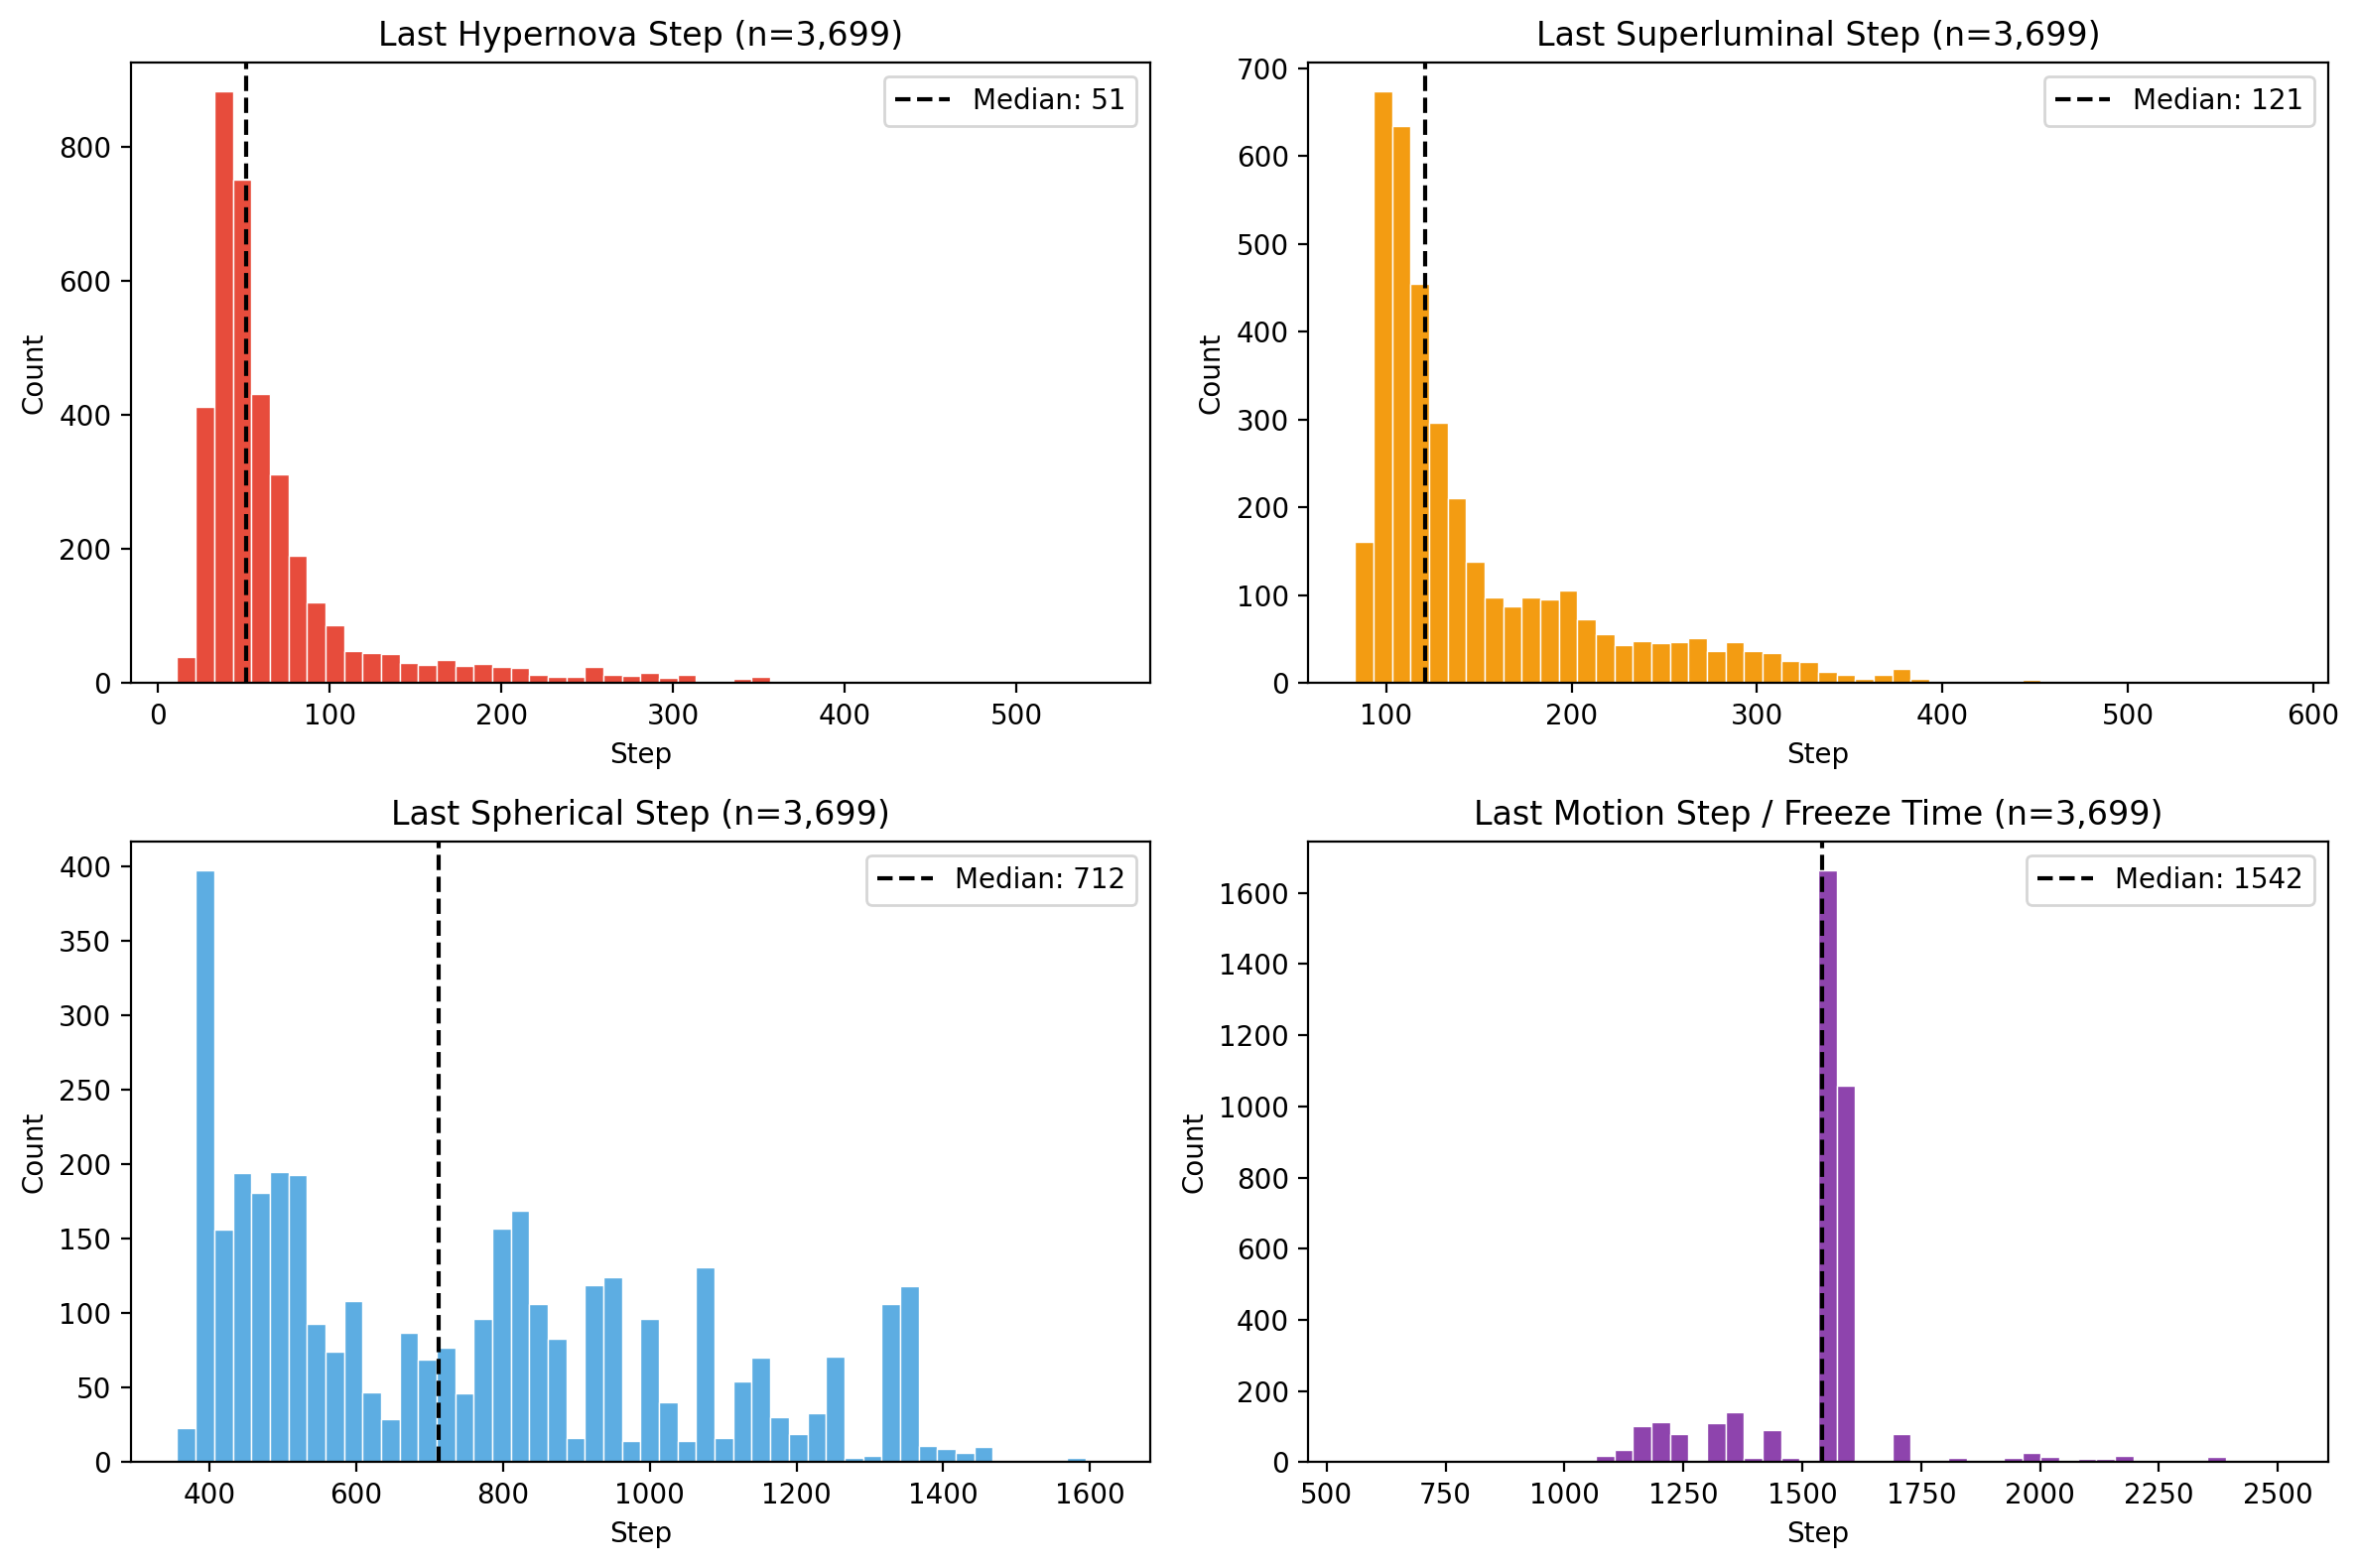

In [9]:
# Histograms of transition times
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Last Hypernova
ax = axes[0, 0]
valid = last_hypernova[last_hypernova >= 0].numpy()
ax.hist(valid, bins=50, color='#e74c3c', edgecolor='white', linewidth=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Count')
ax.set_title(f'Last Hypernova Step (n={len(valid):,})')
ax.axvline(np.median(valid), color='black', linestyle='--', label=f'Median: {np.median(valid):.0f}')
ax.legend()

# Last Superluminal
ax = axes[0, 1]
valid = last_superluminal[last_superluminal >= 0].numpy()
ax.hist(valid, bins=50, color='#f39c12', edgecolor='white', linewidth=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Count')
ax.set_title(f'Last Superluminal Step (n={len(valid):,})')
ax.axvline(np.median(valid), color='black', linestyle='--', label=f'Median: {np.median(valid):.0f}')
ax.legend()

# Last Spherical
ax = axes[1, 0]
valid = last_spherical[last_spherical >= 0].numpy()
ax.hist(valid, bins=50, color='#5dade2', edgecolor='white', linewidth=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Count')
ax.set_title(f'Last Spherical Step (n={len(valid):,})')
ax.axvline(np.median(valid), color='black', linestyle='--', label=f'Median: {np.median(valid):.0f}')
ax.legend()

# Last Motion (freeze time)
ax = axes[1, 1]
valid = last_motion[last_motion >= 0].numpy()
ax.hist(valid, bins=50, color='#8e44ad', edgecolor='white', linewidth=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Count')
ax.set_title(f'Last Motion Step / Freeze Time (n={len(valid):,})')
ax.axvline(np.median(valid), color='black', linestyle='--', label=f'Median: {np.median(valid):.0f}')
ax.legend()

plt.tight_layout()
plt.show()

## Observations

*(To be filled in after viewing the plots)*